In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from scipy.optimize import minimize

#Au material script from complex refractive index data

wvl_data = np.array([250.000000, 260.000000, 270.000000, 280.000000, 290.000000, 300.000000,
                              310.000000, 320.000000, 330.000000, 340.000000, 350.000000, 360.000000,
                              370.000000, 380.000000, 390.000000, 400.000000, 410.000000, 420.000000,
                              430.000000, 440.000000, 450.000000, 460.000000, 470.000000, 480.000000,
                              490.000000, 500.000000, 510.000000, 520.000000, 530.000000, 540.000000,
                              550.000000, 560.000000, 570.000000, 580.000000, 590.000000, 600.000000,
                              610.000000, 620.000000, 630.000000, 640.000000, 650.000000, 660.000000,
                              670.000000, 680.000000, 690.000000, 700.000000, 710.000000, 720.000000,
                              730.000000, 740.000000, 750.000000, 760.000000, 770.000000, 780.000000,
                              790.000000, 800.000000, 810.000000, 820.000000, 830.000000, 840.000000,
                              850.000000, 860.000000, 870.000000, 880.000000, 890.000000, 900.000000,
                              910.000000, 920.000000, 930.000000, 940.000000, 950.000000, 960.000000,
                              970.000000, 980.000000, 990.000000, 1000.000000])

#Refractive index data
n_data = np.array([1.486293, 1.517101, 1.602219, 1.678100, 1.750429, 1.800042, 1.830000, 1.836011,
                   1.813111, 1.781199, 1.751161, 1.726732, 1.706249, 1.687926, 1.670782, 1.658000,
                   1.641467, 1.626593, 1.607286, 1.572004, 1.503407, 1.417996, 1.315496, 1.189871,
                   1.018554, 0.849238, 0.698231, 0.571152, 0.475555, 0.397920, 0.355713, 0.318417,
                   0.295010, 0.278152, 0.261664, 0.245531, 0.229740, 0.214278, 0.199131, 0.184288,
                   0.169737, 0.164060, 0.162125, 0.160792, 0.160087, 0.160906, 0.161863, 0.162930,
                   0.164154, 0.166357, 0.168557, 0.170750, 0.172934, 0.175425, 0.178189, 0.180917,
                   0.183609, 0.186265, 0.189334, 0.193206, 0.197006, 0.200737, 0.204403, 0.208008,
                   0.211773, 0.215750, 0.219658, 0.223500, 0.227279, 0.230997, 0.234659, 0.239028,
                   0.243770, 0.248435, 0.253026, 0.257546])

#Absorption coefficient data (imaginary coefficient of complex refractive index)
k_data = np.array([1.660980, 1.759202, 1.824512, 1.873471, 1.904443, 1.919298, 1.916000, 1.897531,
                   1.870450, 1.852625, 1.847116, 1.855697, 1.883198, 1.916907, 1.939990, 1.956000,
                   1.957488, 1.949527, 1.934151, 1.910625, 1.878436, 1.843614, 1.814717, 1.799925,
                   1.820950, 1.892178, 2.027084, 2.185897, 2.374957, 2.553141, 2.695668, 2.832206,
                   2.899935, 2.930925, 2.961718, 2.992315, 3.022714, 3.052916, 3.082919, 3.112725,
                   3.142334, 3.293285, 3.477580, 3.652616, 3.817434, 3.959739, 4.097111, 4.230027,
                   4.358280, 4.474892, 4.588542, 4.699445, 4.807792, 4.914824, 5.020584, 5.124162,
                   5.225688, 5.325278, 5.419440, 5.505117, 5.589481, 5.672590, 5.754499, 5.835259,
                   5.919898, 6.009588, 6.097960, 6.185070, 6.270970, 6.355709, 6.439333, 6.519685,
                   6.597783, 6.674968, 6.751271, 6.826722])


#Fit the data to Lorentz Function and generate Au material

def lorentzfunc(p: np.ndarray, x: np.ndarray) -> np.ndarray:
    """
    Returns the complex ε profile given a set of Lorentzian parameters p
    (σ_0, ω_0, γ_0, σ_1, ω_1, γ_1, ...) for a set of frequencies x.
    """
    N = len(p) // 3
    y = np.zeros(len(x))
    for n in range(N):
        A_n, x_n, g_n = p[3 * n : 3 * n + 3]
        y = y + A_n / (np.square(x_n) - np.square(x) - 1j * x * g_n)
    return y


def lorentzerr(p: np.ndarray, x: np.ndarray, y: np.ndarray) -> float:
    """
    Returns the error (or residual or loss) as the L2 norm
    of the difference of ε(p,x) and y over a set of frequencies x.
    """
    yp = lorentzfunc(p, x)
    val = np.sum(np.square(abs(y - yp)))
    return val


def lorentzfit(
    p0: np.ndarray,
    x: np.ndarray,
    y: np.ndarray,
    tol: float = 1e-25,
    maxeval: float = 10000,
) -> Tuple[np.ndarray, float]:
    """
    Returns the optimal Lorentzian polarizability parameters and error
    which minimize the error in ε(p0,x) relative to y for an initial
    set of Lorentzian polarizability parameters p0 over a set of
    frequencies x using the scipy.optimize algorithm for a relative
    tolerance tol and a maximum number of iterations maxeval.
    """
    result = minimize(
        lambda p: lorentzerr(p, x, y),
        p0,
        method="L-BFGS-B",
        options={"ftol": tol, "maxiter": maxeval},
    )
    popt = result.x
    minf = result.fun
    return popt, minf


if __name__ == "__main__":
    
    n = n_data[:] + 1j * k_data[:]
    eps_inf = 1.1

    eps = np.square(n) - eps_inf

    wl = wvl_data[:]
    wl_min = 250  # minimum wavelength (units of nm)
    wl_max = 1000  # maximum wavelength (units of nm)
    start_idx = np.where(wl > wl_min)
    idx_start = start_idx[0][0]
    end_idx = np.where(wl < wl_max)
    idx_end = end_idx[0][-1] + 1

    # The fitting function is ε(f) where f is the frequency, rather than ε(λ).
    freqs = 1000 / wl  # units of 1/μm
    freqs_reduced = freqs[idx_start:idx_end]
    wl_reduced = wl[idx_start:idx_end]
    eps_reduced = eps[idx_start:idx_end]

    # Fitting parameter: number of Lorentzian terms to use in the fit
    num_lorentzians = 2

    # Number of times to repeat local optimization with random initial values.
    num_repeat = 30

    ps = np.zeros((num_repeat, 3 * num_lorentzians))
    mins = np.zeros(num_repeat)
    for m in range(num_repeat):
        # Initial values for the Lorentzian polarizability terms. Each term
        # consists of three parameters (σ, ω, γ) and is chosen randomly.
        # Note: for the case of no absorption, γ should be set to zero.
        p_rand = [10 ** (np.random.random()) for _ in range(3 * num_lorentzians)]
        ps[m, :], mins[m] = lorentzfit(p_rand, freqs_reduced, eps_reduced, 1e-25, 50000)
        ps_str = "( " + ", ".join(f"{prm:.4f}" for prm in ps[m, :]) + " )"
        print(f"iteration:, {m:3d}, ps_str, {mins[m]:.6f}")

    # Find the best performing set of parameters.
    idx_opt = np.argmin(mins)
    popt_str = "( " + ", ".join(f"{prm:.4f}" for prm in ps[idx_opt]) + " )"
    print(f"optimal:, {popt_str}, {mins[idx_opt]:.6f}")

    # Define a `Medium` class object using the optimal fitting parameters.
    E_susceptibilities = []

    for n in range(num_lorentzians):
        mymaterial_freq, mymaterial_gamma = ps[idx_opt][3 * n + 1:3 * n + 3]

        if mymaterial_freq == 0:
            mymaterial_sigma = ps[idx_opt][3 * n + 0]
            E_susceptibilities.append(
                mp.DrudeSusceptibility(
                    frequency=1.0, gamma=mymaterial_gamma, sigma=mymaterial_sigma
                )
            )
        else:
            mymaterial_sigma = ps[idx_opt][3 * n + 0] / mymaterial_freq**2
            E_susceptibilities.append(
                mp.LorentzianSusceptibility(
                    frequency=mymaterial_freq,
                    gamma=mymaterial_gamma,
                    sigma=mymaterial_sigma,
                )
            )

    Au = mp.Medium(epsilon=eps_inf, E_susceptibilities=E_susceptibilities)

iteration:,   0, ps_str, 13044.736016
iteration:,   1, ps_str, 148.081582
iteration:,   2, ps_str, 13041.628473
iteration:,   3, ps_str, 514.959467
iteration:,   4, ps_str, 13041.693599
iteration:,   5, ps_str, 13042.811422
iteration:,   6, ps_str, 13044.348440
iteration:,   7, ps_str, 881.863497
iteration:,   8, ps_str, 300.576753
iteration:,   9, ps_str, 13043.134872
iteration:,  10, ps_str, 148.081582
iteration:,  11, ps_str, 148.081582
iteration:,  12, ps_str, 13042.474422
iteration:,  13, ps_str, 148.081582
iteration:,  14, ps_str, 514.339317
iteration:,  15, ps_str, 13041.454065
iteration:,  16, ps_str, 148.081582
iteration:,  17, ps_str, 148.081582
iteration:,  18, ps_str, 13041.832428
iteration:,  19, ps_str, 1282.144859
iteration:,  20, ps_str, 148.081582
iteration:,  21, ps_str, 148.081582
iteration:,  22, ps_str, 1282.172926
iteration:,  23, ps_str, 13043.407067
iteration:,  24, ps_str, 148.081582
iteration:,  25, ps_str, 1282.156098
iteration:,  26, ps_str, 13045.739766
ite

In [2]:
#Coupling nanosphere scattering spectrum

import meep as mp
import numpy as np
import matplotlib.pyplot as plt


def get_spectrum_coupling(radius, gap, wvl_min, wvl_max):

    
    #default medium is water
    default_material = mp.Medium(index=1.3325)
    
    
    frq_min = 1 / wvl_max
    frq_max = 1 / wvl_min
    frq_cen = 0.5 * (frq_min + frq_max)
    dfrq = frq_max - frq_min
    nfrq = 100
    
    resolution = 65/r
    
    dpml = 2*r
    dair = 2*r
    
    pml_layers = [mp.PML(thickness=dpml)]
    
    #symmetries = [mp.Mirror(mp.Y)]
    
    width = 2 * (dpml + dair + r)
    height = 2 * (dpml + dair + 2*r + 0.5*gap)
    cell_size = mp.Vector3(width, height)
    
    # is_integrated=True necessary for any planewave source extending into PML
    sources = [
    mp.Source(
        mp.GaussianSource(frq_cen, fwidth=dfrq, is_integrated=True),
        center=mp.Vector3(-0.5 * width + dpml, 0),
        size=mp.Vector3(0, height),
        component=mp.Hz)
    ]
    
    
    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        default_material = default_material,
        sources=sources,
        k_point=mp.Vector3()
    )

    f_height = gap + 4*r
    f_width = 2*r

    box_x1 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(x=-r), size=mp.Vector3(0, f_height)),
    )
    box_x2 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(x=+r), size=mp.Vector3(0, f_height)),
    )
    box_y1 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(y=-r), size=mp.Vector3(f_width, 0)),
    )
    box_y2 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(y=+r), size=mp.Vector3(f_width, 0)),
    )
    
    sim.run(until_after_sources=10)
    
    freqs = mp.get_flux_freqs(box_x1)
    box_x1_data = sim.get_flux_data(box_x1)
    box_x2_data = sim.get_flux_data(box_x2)
    box_y1_data = sim.get_flux_data(box_y1)
    box_y2_data = sim.get_flux_data(box_y2)
    
    box_x1_flux0 = mp.get_fluxes(box_x1)
    
    sim.reset_meep()


    
    geometry = [
        mp.Sphere(material=Au,
                  center=mp.Vector3(0, 0.5*gap + r),
                  radius=r),
        mp.Sphere(material=Au,
                  center=mp.Vector3(0, -0.5*gap - r),
                  radius=r),
    ]
    
    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        sources=sources,
        default_material = default_material,
        k_point=mp.Vector3(),
        geometry=geometry,
    )
    
    box_x1 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(x=-r), size=mp.Vector3(0, f_height)),
    )
    box_x2 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(x=+r), size=mp.Vector3(0, f_height)),
    )
    box_y1 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(y=-r), size=mp.Vector3(f_width, 0)),
    )
    box_y2 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(y=+r), size=mp.Vector3(f_width, 0)),
    )
    
    sim.load_minus_flux_data(box_x1, box_x1_data)
    sim.load_minus_flux_data(box_x2, box_x2_data)
    sim.load_minus_flux_data(box_y1, box_y1_data)
    sim.load_minus_flux_data(box_y2, box_y2_data)
    
    sim.run(until_after_sources=100)
    
    #flux power through each flux region.
    box_x1_flux = mp.get_fluxes(box_x1)
    box_x2_flux = mp.get_fluxes(box_x2)
    box_y1_flux = mp.get_fluxes(box_y1)
    box_y2_flux = mp.get_fluxes(box_y2)

    
    #Just want to plot the power of the scattered flux against wavelength
    scatt_flux = (
        np.asarray(box_x1_flux)
        - np.asarray(box_x2_flux)
        + np.asarray(box_y1_flux)
        - np.asarray(box_y2_flux)
    )

    return scatt_flux, freqs


In [3]:
#Varying Radius

wvl_min = 400E-3
wvl_max = 1000E-3

gap = 50E-3

freq_data = []  #Going to append all raw sim data arrays, to process and plot after the runs
scatt_data = []

r_min =15E-3
r_max =180E-3
radii = np.linspace(r_max,r_min,20)

index = 1

for r in radii:
    print(f"##################### Run {index} Starting #######################")
    scatt_flux, freqs = get_spectrum_coupling(r, gap, wvl_min, wvl_max)
    scatt_data.append(scatt_flux)
    freq_data.append(freqs)

    index+=1

##################### Run 1 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00123286 s
Working in 2D dimensions.
Computational cell is 1.8 x 2.21082 x 0 with resolution 472.222
time for set_epsilon = 1.50173 s
-----------
Meep progress: 0.38647058823529407/16.666666507720947 = 2.3% done in 4.0s, 168.8s to go
on time step 365 (time=0.386471), 0.0109759 s/step
Meep progress: 0.7856470588235294/16.666666507720947 = 4.7% done in 8.0s, 162.1s to go
on time step 742 (time=0.785647), 0.0106378 s/step
Meep progress: 1.1805882352941175/16.666666507720947 = 7.1% done in 12.0s, 157.8s to go
on time step 1115 (time=1.18059), 0.0107472 s/step
Meep progress: 1.5659999999999998/16.666666507720947 = 9.4% done in 16.0s, 154.6s to go
on time step 1479 (time=1.566), 0.0110098 s/step
Meep progress: 1.965176470588235/16.666666507720947 = 11.8% done in 20.0s, 149.9s to go
on time step 1856 (time=1.96518), 0.0106144 s/step
Meep progress: 2.366470588235

run 0 finished at t = 16.666941176470587 (15741 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00103283 s
Working in 2D dimensions.
Computational cell is 1.8 x 2.21082 x 0 with resolution 472.222
     sphere, center = (0,0.205,0)
          radius 0.18
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.205,0)
          radius 0.18
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 1.5605 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.16835294117647057/106.66666650772095 = 0.2% done in 4.0s, 2536.4s to go
on time step 159 (time=0.168353), 0.0252183 s/step
Meep progress: 0.3504705882352941/106.66666650772095 = 0.3% done in 8.0s, 2435.0s to go
on time step 331 (time=0.350471), 0.0233484 s/step
Meep progress: 0.526235294117647/106.66666650772095 = 0.5% done in 12.0s, 2426.4s 

run 0 finished at t = 106.66694117647057 (100741 timesteps)
##################### Run 2 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00163984 s
Working in 2D dimensions.
Computational cell is 1.71316 x 2.10618 x 0 with resolution 496.16
time for set_epsilon = 1.95075 s
-----------
Meep progress: 0.33255417956656347/16.666666507720947 = 2.0% done in 4.0s, 196.7s to go
on time step 330 (time=0.332554), 0.0121366 s/step
Meep progress: 0.6852631578947368/16.666666507720947 = 4.1% done in 8.0s, 186.9s to go
on time step 680 (time=0.685263), 0.0114506 s/step
Meep progress: 1.0490572755417957/16.666666507720947 = 6.3% done in 12.0s, 179.0s to go
on time step 1041 (time=1.04906), 0.0110973 s/step
Meep progress: 1.417890092879257/16.666666507720947 = 8.5% done in 16.0s, 172.3s to go
on time step 1407 (time=1.41789), 0.0109382 s/step
Meep progress: 1.812924148606811/16.666666507720947 = 10.9% done in 20.0s, 164.2s to go
on time step 179

run 0 finished at t = 16.667010835913313 (16539 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00104403 s
Working in 2D dimensions.
Computational cell is 1.71316 x 2.10618 x 0 with resolution 496.16
     sphere, center = (0,0.196316,0)
          radius 0.171316
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.196316,0)
          radius 0.171316
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 1.70628 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.17030804953560372/106.66666650772095 = 0.2% done in 4.0s, 2513.0s to go
on time step 169 (time=0.170308), 0.0237805 s/step
Meep progress: 0.3396083591331269/106.66666650772095 = 0.3% done in 8.0s, 2514.6s to go
on time step 337 (time=0.339608), 0.023882 s/step
Meep progress: 0.5139473684210526/106.66666650772095 = 0.5% done 

run 0 finished at t = 106.66725696594428 (105848 timesteps)
##################### Run 3 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00133896 s
Working in 2D dimensions.
Computational cell is 1.62632 x 2.00133 x 0 with resolution 522.654
time for set_epsilon = 1.45132 s
-----------
Meep progress: 0.3625727554179566/16.666666507720947 = 2.2% done in 4.0s, 179.9s to go
on time step 379 (time=0.362573), 0.0105589 s/step
Meep progress: 0.7385386996904023/16.666666507720947 = 4.4% done in 8.0s, 172.7s to go
on time step 772 (time=0.738539), 0.0101969 s/step
Meep progress: 1.1240712074303403/16.666666507720947 = 6.7% done in 12.0s, 166.1s to go
on time step 1175 (time=1.12407), 0.00993643 s/step
Meep progress: 1.5134303405572753/16.666666507720947 = 9.1% done in 16.0s, 160.5s to go
on time step 1582 (time=1.51343), 0.00985056 s/step
Meep progress: 1.884613003095975/16.666666507720947 = 11.3% done in 20.0s, 157.1s to go
on time step 

run 0 finished at t = 16.666866873065015 (17422 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000946999 s
Working in 2D dimensions.
Computational cell is 1.62632 x 2.00133 x 0 with resolution 522.654
     sphere, center = (0,0.187632,0)
          radius 0.162632
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.187632,0)
          radius 0.162632
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 1.54034 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.17315479876160988/106.66666650772095 = 0.2% done in 4.0s, 2467.2s to go
on time step 181 (time=0.173155), 0.0221644 s/step
Meep progress: 0.3587461300309597/106.66666650772095 = 0.3% done in 8.0s, 2378.0s to go
on time step 375 (time=0.358746), 0.0206811 s/step
Meep progress: 0.5452941176470587/106.66666650772095 = 0.5% do

Meep progress: 106.66239938080494/106.66666650772095 = 100.0% done in 2318.3s, 0.1s to go
run 0 finished at t = 106.66718266253868 (111500 timesteps)
##################### Run 4 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00144506 s
Working in 2D dimensions.
Computational cell is 1.53947 x 1.89808 x 0 with resolution 552.137
time for set_epsilon = 1.42844 s
-----------
Meep progress: 0.36404024767801857/16.666666507720947 = 2.2% done in 4.0s, 179.4s to go
on time step 402 (time=0.36404), 0.00996692 s/step
Meep progress: 0.7480030959752322/16.666666507720947 = 4.5% done in 8.0s, 170.5s to go
on time step 826 (time=0.748003), 0.00944027 s/step
Meep progress: 1.128343653250774/16.666666507720947 = 6.8% done in 12.0s, 165.5s to go
on time step 1246 (time=1.12834), 0.00953505 s/step
Meep progress: 1.5005340557275542/16.666666507720947 = 9.0% done in 16.0s, 161.9s to go
on time step 1657 (time=1.50053), 0.00974236 s/step
Meep progr

run 0 finished at t = 16.66706656346749 (18405 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00099802 s
Working in 2D dimensions.
Computational cell is 1.53947 x 1.89808 x 0 with resolution 552.137
     sphere, center = (0,0.178947,0)
          radius 0.153947
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.178947,0)
          radius 0.153947
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 1.69852 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.18020897832817337/106.66666650772095 = 0.2% done in 4.0s, 2366.0s to go
on time step 199 (time=0.180209), 0.0201215 s/step
Meep progress: 0.3685681114551083/106.66666650772095 = 0.3% done in 8.0s, 2309.2s to go
on time step 407 (time=0.368568), 0.0192395 s/step
Meep progress: 0.5451547987616099/106.66666650772095 = 0.5% done

run 0 finished at t = 106.6674148606811 (117790 timesteps)
##################### Run 5 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00105786 s
Working in 2D dimensions.
Computational cell is 1.45263 x 1.79272 x 0 with resolution 585.145
time for set_epsilon = 1.33095 s
-----------
Meep progress: 0.3486315789473684/16.666666507720947 = 2.1% done in 4.0s, 187.3s to go
on time step 408 (time=0.348632), 0.00980643 s/step
Meep progress: 0.704953560371517/16.666666507720947 = 4.2% done in 8.0s, 181.3s to go
on time step 825 (time=0.704954), 0.00961058 s/step
Meep progress: 1.0476037151702786/16.666666507720947 = 6.3% done in 12.0s, 179.1s to go
on time step 1226 (time=1.0476), 0.00997793 s/step
Meep progress: 1.4039256965944273/16.666666507720947 = 8.4% done in 16.0s, 174.1s to go
on time step 1643 (time=1.40393), 0.00959558 s/step
Meep progress: 1.7534117647058824/16.666666507720947 = 10.5% done in 20.0s, 170.2s to go
on time step 

run 0 finished at t = 16.666811145510835 (19505 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000908136 s
Working in 2D dimensions.
Computational cell is 1.45263 x 1.79272 x 0 with resolution 585.145
     sphere, center = (0,0.170263,0)
          radius 0.145263
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.170263,0)
          radius 0.145263
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 1.71581 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.1632074303405573/106.66666650772095 = 0.2% done in 4.0s, 2629.5s to go
on time step 191 (time=0.163207), 0.0210978 s/step
Meep progress: 0.32897832817337463/106.66666650772095 = 0.3% done in 8.0s, 2600.7s to go
on time step 385 (time=0.328978), 0.020698 s/step
Meep progress: 0.5007306501547988/106.66666650772095 = 0.5% don

run 0 finished at t = 106.66673684210527 (124831 timesteps)
##################### Run 6 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.0010581 s
Working in 2D dimensions.
Computational cell is 1.36579 x 1.68876 x 0 with resolution 622.351
time for set_epsilon = 1.46629 s
-----------
Meep progress: 0.31975541795665635/16.666666507720947 = 1.9% done in 4.0s, 204.5s to go
on time step 398 (time=0.319755), 0.0100517 s/step
Meep progress: 0.6563823529411764/16.666666507720947 = 3.9% done in 8.0s, 195.2s to go
on time step 818 (time=0.657186), 0.00954461 s/step
Meep progress: 0.993812693498452/16.666666507720947 = 6.0% done in 12.0s, 189.4s to go
on time step 1238 (time=0.994616), 0.00953654 s/step
Meep progress: 1.3248157894736843/16.666666507720947 = 7.9% done in 16.0s, 185.4s to go
on time step 1651 (time=1.32642), 0.00970513 s/step
Meep progress: 1.6622461300309597/16.666666507720947 = 10.0% done in 20.0s, 180.6s to go
on time ste

run 0 finished at t = 16.6674520123839 (20746 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00102878 s
Working in 2D dimensions.
Computational cell is 1.36579 x 1.68876 x 0 with resolution 622.351
     sphere, center = (0,0.161579,0)
          radius 0.136579
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.161579,0)
          radius 0.136579
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 1.59125 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.15827089783281734/106.66666650772095 = 0.1% done in 4.0s, 2702.8s to go
on time step 197 (time=0.158271), 0.0203887 s/step
Meep progress: 0.3237724458204334/106.66666650772095 = 0.3% done in 8.0s, 2634.1s to go
on time step 403 (time=0.323772), 0.019428 s/step
Meep progress: 0.4796331269349845/106.66666650772095 = 0.4% done i

run 0 finished at t = 106.66735448916408 (132769 timesteps)
##################### Run 7 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00107408 s
Working in 2D dimensions.
Computational cell is 1.27895 x 1.58439 x 0 with resolution 664.609
time for set_epsilon = 1.53488 s
-----------
Meep progress: 0.29716718266253866/16.666666507720947 = 1.8% done in 4.0s, 220.8s to go
on time step 395 (time=0.297167), 0.0101466 s/step
Meep progress: 0.5950866873065015/16.666666507720947 = 3.6% done in 8.0s, 216.4s to go
on time step 791 (time=0.595087), 0.0101137 s/step
Meep progress: 0.9020340557275541/16.666666507720947 = 5.4% done in 12.0s, 210.0s to go
on time step 1199 (time=0.902034), 0.00981009 s/step
Meep progress: 1.2074767801857584/16.666666507720947 = 7.2% done in 16.0s, 205.1s to go
on time step 1605 (time=1.20748), 0.00985866 s/step
Meep progress: 1.5129195046439627/16.666666507720947 = 9.1% done in 20.0s, 200.6s to go
on time ste

run 0 finished at t = 16.666941176470587 (22154 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.001297 s
Working in 2D dimensions.
Computational cell is 1.27895 x 1.58439 x 0 with resolution 664.609
     sphere, center = (0,0.152895,0)
          radius 0.127895
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.152895,0)
          radius 0.127895
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 1.87267 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.1459504643962848/106.66666650772095 = 0.1% done in 4.0s, 2928.1s to go
on time step 194 (time=0.14595), 0.0206814 s/step
Meep progress: 0.2949102167182662/106.66666650772095 = 0.3% done in 8.0s, 2890.5s to go
on time step 392 (time=0.29491), 0.0202079 s/step
Meep progress: 0.4461269349845201/106.66666650772095 = 0.4% done in 

run 0 finished at t = 106.66721981424148 (141784 timesteps)
##################### Run 8 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00109005 s
Working in 2D dimensions.
Computational cell is 1.19211 x 1.48102 x 0 with resolution 713.024
time for set_epsilon = 1.47412 s
-----------
Meep progress: 0.2594582043343653/16.666666507720947 = 1.6% done in 4.0s, 253.5s to go
on time step 370 (time=0.259458), 0.010836 s/step
Meep progress: 0.5378498452012382/16.666666507720947 = 3.2% done in 8.0s, 240.3s to go
on time step 767 (time=0.53785), 0.0100829 s/step
Meep progress: 0.7931006191950463/16.666666507720947 = 4.8% done in 12.0s, 240.6s to go
on time step 1131 (time=0.793101), 0.0110089 s/step
Meep progress: 1.0693885448916407/16.666666507720947 = 6.4% done in 16.0s, 233.8s to go
on time step 1525 (time=1.06939), 0.0101704 s/step
Meep progress: 1.3421702786377705/16.666666507720947 = 8.1% done in 20.0s, 228.7s to go
on time step 191

run 0 finished at t = 16.66703405572755 (23768 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00128388 s
Working in 2D dimensions.
Computational cell is 1.19211 x 1.48102 x 0 with resolution 713.024
     sphere, center = (0,0.144211,0)
          radius 0.119211
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.144211,0)
          radius 0.119211
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 1.71963 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.13884520123839006/106.66666650772095 = 0.1% done in 4.0s, 3069.9s to go
on time step 198 (time=0.138845), 0.0202087 s/step
Meep progress: 0.2762879256965944/106.66666650772095 = 0.3% done in 8.0s, 3088.0s to go
on time step 394 (time=0.276288), 0.0204972 s/step
Meep progress: 0.41513312693498444/106.66666650772095 = 0.4% don

run 0 finished at t = 106.66677399380802 (152112 timesteps)
##################### Run 9 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00125504 s
Working in 2D dimensions.
Computational cell is 1.10526 x 1.37573 x 0 with resolution 769.048
time for set_epsilon = 1.48384 s
-----------
Meep progress: 0.2561609907120743/16.666666507720947 = 1.5% done in 4.0s, 256.8s to go
on time step 394 (time=0.256161), 0.0101734 s/step
Meep progress: 0.5129721362229103/16.666666507720947 = 3.1% done in 8.0s, 252.3s to go
on time step 789 (time=0.512972), 0.0101352 s/step
Meep progress: 0.7743343653250774/16.666666507720947 = 4.6% done in 12.0s, 246.7s to go
on time step 1191 (time=0.774334), 0.00996309 s/step
Meep progress: 1.0330959752321982/16.666666507720947 = 6.2% done in 16.0s, 242.4s to go
on time step 1589 (time=1.0331), 0.0100543 s/step
Meep progress: 1.3029102167182662/16.666666507720947 = 7.8% done in 20.0s, 236.2s to go
on time step 2

run 0 finished at t = 16.66671826625387 (25635 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000960112 s
Working in 2D dimensions.
Computational cell is 1.10526 x 1.37573 x 0 with resolution 769.048
     sphere, center = (0,0.135526,0)
          radius 0.110526
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.135526,0)
          radius 0.110526
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 1.60423 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.12938080495356039/106.66666650772095 = 0.1% done in 4.0s, 3303.0s to go
on time step 199 (time=0.129381), 0.020158 s/step
Meep progress: 0.25681114551083595/106.66666650772095 = 0.2% done in 8.0s, 3322.5s to go
on time step 395 (time=0.256811), 0.0204408 s/step
Meep progress: 0.3809907120743034/106.66666650772095 = 0.4% don

run 0 finished at t = 106.66699690402477 (164064 timesteps)
##################### Run 10 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00116301 s
Working in 2D dimensions.
Computational cell is 1.01842 x 1.27243 x 0 with resolution 834.625
time for set_epsilon = 1.37277 s
-----------
Meep progress: 0.2306424148606811/16.666666507720947 = 1.4% done in 4.0s, 285.6s to go
on time step 385 (time=0.230642), 0.0104088 s/step
Meep progress: 0.4594876160990712/16.666666507720947 = 2.8% done in 8.0s, 282.6s to go
on time step 767 (time=0.459488), 0.0104812 s/step
Meep progress: 0.7027105263157895/16.666666507720947 = 4.2% done in 12.0s, 273.0s to go
on time step 1173 (time=0.702711), 0.0098578 s/step
Meep progress: 0.9255650154798761/16.666666507720947 = 5.6% done in 16.0s, 272.4s to go
on time step 1545 (time=0.925565), 0.0107562 s/step
Meep progress: 1.162797213622291/16.666666507720947 = 7.0% done in 20.0s, 267.0s to go
on time step 

run 0 finished at t = 16.666760061919504 (27821 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00116897 s
Working in 2D dimensions.
Computational cell is 1.01842 x 1.27243 x 0 with resolution 834.625
     sphere, center = (0,0.126842,0)
          radius 0.101842
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.126842,0)
          radius 0.101842
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 1.75725 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.10603560371517028/106.66666650772095 = 0.1% done in 4.0s, 4025.8s to go
on time step 177 (time=0.106036), 0.0226333 s/step
Meep progress: 0.22225541795665635/106.66666650772095 = 0.2% done in 8.0s, 3836.6s to go
on time step 371 (time=0.222255), 0.0206378 s/step
Meep progress: 0.33308359133126936/106.66666650772095 = 0.3% d

run 0 finished at t = 106.66702476780186 (178054 timesteps)
##################### Run 11 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00130606 s
Working in 2D dimensions.
Computational cell is 0.931579 x 1.16831 x 0 with resolution 912.429
time for set_epsilon = 1.31928 s
-----------
Meep progress: 0.21207120743034055/16.666666507720947 = 1.3% done in 4.0s, 310.7s to go
on time step 387 (time=0.212071), 0.0103464 s/step
Meep progress: 0.4252383900928792/16.666666507720947 = 2.6% done in 8.0s, 305.8s to go
on time step 776 (time=0.425238), 0.0102897 s/step
Meep progress: 0.6411455108359133/16.666666507720947 = 3.8% done in 12.0s, 300.3s to go
on time step 1170 (time=0.641146), 0.0101705 s/step
Meep progress: 0.8515727554179566/16.666666507720947 = 5.1% done in 16.0s, 297.5s to go
on time step 1554 (time=0.851573), 0.0104301 s/step
Meep progress: 1.0658359133126933/16.666666507720947 = 6.4% done in 20.0s, 293.1s to go
on time st

run 0 finished at t = 16.66704334365325 (30415 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000915051 s
Working in 2D dimensions.
Computational cell is 0.931579 x 1.16831 x 0 with resolution 912.429
     sphere, center = (0,0.118158,0)
          radius 0.0931579
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.118158,0)
          radius 0.0931579
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 1.67702 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.09918575851393188/106.66666650772095 = 0.1% done in 4.0s, 4299.5s to go
on time step 181 (time=0.0991858), 0.0221096 s/step
Meep progress: 0.20604334365325075/106.66666650772095 = 0.2% done in 8.0s, 4141.5s to go
on time step 376 (time=0.206043), 0.0205801 s/step
Meep progress: 0.30906501547987614/106.66666650772095 = 0.

run 0 finished at t = 106.6668854489164 (194652 timesteps)
##################### Run 12 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00123501 s
Working in 2D dimensions.
Computational cell is 0.844737 x 1.06337 x 0 with resolution 1006.23
time for set_epsilon = 1.38431 s
-----------
Meep progress: 0.18981733746130033/16.666666507720947 = 1.1% done in 4.0s, 347.6s to go
on time step 382 (time=0.189817), 0.0104844 s/step
Meep progress: 0.38261609907120747/16.666666507720947 = 2.3% done in 8.0s, 340.9s to go
on time step 770 (time=0.382616), 0.0103223 s/step
Meep progress: 0.5724334365325078/16.666666507720947 = 3.4% done in 12.0s, 337.9s to go
on time step 1152 (time=0.572433), 0.0104922 s/step
Meep progress: 0.7657291021671827/16.666666507720947 = 4.6% done in 16.0s, 332.7s to go
on time step 1541 (time=0.765729), 0.0102919 s/step
Meep progress: 0.9520681114551084/16.666666507720947 = 5.7% done in 20.0s, 330.6s to go
on time st

run 0 finished at t = 16.66715479876161 (33542 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00127792 s
Working in 2D dimensions.
Computational cell is 0.844737 x 1.06337 x 0 with resolution 1006.23
     sphere, center = (0,0.109474,0)
          radius 0.0844737
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.109474,0)
          radius 0.0844737
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 1.68892 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.09242414860681115/106.66666650772095 = 0.1% done in 4.0s, 4626.4s to go
on time step 186 (time=0.0924241), 0.0215715 s/step
Meep progress: 0.18435139318885452/106.66666650772095 = 0.2% done in 8.0s, 4633.7s to go
on time step 371 (time=0.184351), 0.0216724 s/step
Meep progress: 0.27826625386996906/106.66666650772095 = 0.3

run 0 finished at t = 106.66690866873066 (214663 timesteps)
##################### Run 13 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000899076 s
Working in 2D dimensions.
Computational cell is 0.757895 x 0.959406 x 0 with resolution 1121.53
time for set_epsilon = 1.48286 s
-----------
Meep progress: 0.16539938080495356/16.666666507720947 = 1.0% done in 4.0s, 399.9s to go
on time step 371 (time=0.165399), 0.0108054 s/step
Meep progress: 0.33570278637770895/16.666666507720947 = 2.0% done in 8.0s, 389.7s to go
on time step 753 (time=0.335703), 0.0104742 s/step
Meep progress: 0.5028854489164086/16.666666507720947 = 3.0% done in 12.0s, 386.1s to go
on time step 1128 (time=0.502885), 0.0106672 s/step
Meep progress: 0.6718513931888545/16.666666507720947 = 4.0% done in 16.0s, 381.3s to go
on time step 1507 (time=0.671851), 0.0105673 s/step
Meep progress: 0.844829721362229/16.666666507720947 = 5.1% done in 20.0s, 375.1s to go
on time 

run 0 finished at t = 16.666996904024767 (37385 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000990152 s
Working in 2D dimensions.
Computational cell is 0.757895 x 0.959406 x 0 with resolution 1121.53
     sphere, center = (0,0.100789,0)
          radius 0.0757895
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.100789,0)
          radius 0.0757895
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 1.5384 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.07980185758513932/106.66666650772095 = 0.1% done in 4.0s, 5344.9s to go
on time step 179 (time=0.0798019), 0.0223572 s/step
Meep progress: 0.16941176470588235/106.66666650772095 = 0.2% done in 8.0s, 5039.2s to go
on time step 380 (time=0.169412), 0.0199689 s/step
Meep progress: 0.2541176470588235/106.66666650772095 = 0.

run 0 finished at t = 106.66699690402476 (239260 timesteps)
##################### Run 14 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000956059 s
Working in 2D dimensions.
Computational cell is 0.671053 x 0.855 x 0 with resolution 1266.67
time for set_epsilon = 1.50721 s
-----------
Meep progress: 0.15710526315789472/16.666666507720947 = 0.9% done in 4.0s, 421.0s to go
on time step 398 (time=0.157105), 0.0100672 s/step
Meep progress: 0.315/16.666666507720947 = 1.9% done in 8.0s, 415.7s to go
on time step 798 (time=0.315), 0.0100033 s/step
Meep progress: 0.4701315789473684/16.666666507720947 = 2.8% done in 12.0s, 413.8s to go
on time step 1191 (time=0.470132), 0.010181 s/step
Meep progress: 0.6248684210526315/16.666666507720947 = 3.7% done in 16.0s, 411.1s to go
on time step 1583 (time=0.624868), 0.0102104 s/step
Meep progress: 0.7760526315789473/16.666666507720947 = 4.7% done in 20.0s, 409.9s to go
on time step 1966 (time=0.77

run 0 finished at t = 16.666973684210525 (42223 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000946999 s
Working in 2D dimensions.
Computational cell is 0.671053 x 0.855 x 0 with resolution 1266.67
     sphere, center = (0,0.0921053,0)
          radius 0.0671053
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0921053,0)
          radius 0.0671053
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 1.63399 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.07263157894736842/106.66666650772095 = 0.1% done in 4.0s, 5892.7s to go
on time step 184 (time=0.0726316), 0.0218228 s/step
Meep progress: 0.15/106.66666650772095 = 0.1% done in 8.0s, 5701.0s to go
on time step 380 (time=0.15), 0.0204717 s/step
Meep progress: 0.22736842105263158/106.66666650772095 = 0.2% done in 12.0s, 

run 0 finished at t = 106.66697368421052 (270223 timesteps)
##################### Run 15 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000959873 s
Working in 2D dimensions.
Computational cell is 0.584211 x 0.751226 x 0 with resolution 1454.95
time for set_epsilon = 1.41576 s
-----------
Meep progress: 0.15601857585139317/16.666666507720947 = 0.9% done in 4.0s, 423.6s to go
on time step 454 (time=0.156019), 0.00881699 s/step
Meep progress: 0.3027585139318885/16.666666507720947 = 1.8% done in 8.0s, 432.7s to go
on time step 881 (time=0.302759), 0.00937374 s/step
Meep progress: 0.440907120743034/16.666666507720947 = 2.6% done in 12.0s, 442.0s to go
on time step 1283 (time=0.440907), 0.00996176 s/step
Meep progress: 0.5903962848297213/16.666666507720947 = 3.5% done in 16.0s, 436.1s to go
on time step 1718 (time=0.590396), 0.00920473 s/step
Meep progress: 0.7299195046439628/16.666666507720947 = 4.4% done in 20.0s, 437.3s to go
on ti

run 0 finished at t = 16.666839009287923 (48499 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000956059 s
Working in 2D dimensions.
Computational cell is 0.584211 x 0.751226 x 0 with resolution 1454.95
     sphere, center = (0,0.0834211,0)
          radius 0.0584211
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0834211,0)
          radius 0.0584211
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 1.7313 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.06907430340557275/106.66666650772095 = 0.1% done in 4.0s, 6184.3s to go
on time step 201 (time=0.0690743), 0.0199379 s/step
Meep progress: 0.13505572755417955/106.66666650772095 = 0.1% done in 8.0s, 6318.4s to go
on time step 393 (time=0.135056), 0.0208452 s/step
Meep progress: 0.20069349845201237/106.66666650772095 =

run 0 finished at t = 106.6668761609907 (310391 timesteps)
##################### Run 16 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.0013442 s
Working in 2D dimensions.
Computational cell is 0.497368 x 0.646579 x 0 with resolution 1708.99
time for set_epsilon = 1.59821 s
-----------
Meep progress: 0.10181424148606813/16.666666507720947 = 0.6% done in 4.0s, 652.2s to go
on time step 348 (time=0.101814), 0.0115194 s/step
Meep progress: 0.20830959752321984/16.666666507720947 = 1.2% done in 8.0s, 633.4s to go
on time step 712 (time=0.20831), 0.0110106 s/step
Meep progress: 0.31451238390092884/16.666666507720947 = 1.9% done in 12.0s, 625.1s to go
on time step 1075 (time=0.314512), 0.0110327 s/step
Meep progress: 0.4201300309597524/16.666666507720947 = 2.5% done in 16.0s, 620.0s to go
on time step 1436 (time=0.42013), 0.0111016 s/step
Meep progress: 0.5269179566563469/16.666666507720947 = 3.2% done in 20.0s, 614.0s to go
on time ste

run 0 finished at t = 16.666815789473688 (56967 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.0016098 s
Working in 2D dimensions.
Computational cell is 0.497368 x 0.646579 x 0 with resolution 1708.99
     sphere, center = (0,0.0747368,0)
          radius 0.0497368
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0747368,0)
          radius 0.0497368
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 1.88218 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.04856656346749227/106.66666650772095 = 0.0% done in 4.0s, 8829.4s to go
on time step 166 (time=0.0485666), 0.0242294 s/step
Meep progress: 0.09918111455108361/106.66666650772095 = 0.1% done in 8.0s, 8633.6s to go
on time step 339 (time=0.0991811), 0.0231911 s/step
Meep progress: 0.1538916408668731/106.66666650772095 = 

run 0 finished at t = 106.66680185758516 (364586 timesteps)
##################### Run 17 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00249505 s
Working in 2D dimensions.
Computational cell is 0.410526 x 0.542861 x 0 with resolution 2070.51
time for set_epsilon = 1.6067 s
-----------
Meep progress: 0.09176470588235294/16.666666507720947 = 0.6% done in 4.0s, 724.1s to go
on time step 380 (time=0.0917647), 0.0105504 s/step
Meep progress: 0.1796656346749226/16.666666507720947 = 1.1% done in 8.0s, 736.2s to go
on time step 744 (time=0.179666), 0.0110231 s/step
Meep progress: 0.27336222910216723/16.666666507720947 = 1.6% done in 12.0s, 721.1s to go
on time step 1132 (time=0.273362), 0.0103127 s/step
Meep progress: 0.3639195046439629/16.666666507720947 = 2.2% done in 16.0s, 718.1s to go
on time step 1507 (time=0.36392), 0.0106811 s/step
Meep progress: 0.45930650154798763/16.666666507720947 = 2.8% done in 20.0s, 707.1s to go
on time 

run 0 finished at t = 16.66688544891641 (69018 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00131702 s
Working in 2D dimensions.
Computational cell is 0.410526 x 0.542861 x 0 with resolution 2070.51
     sphere, center = (0,0.0660526,0)
          radius 0.0410526
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0660526,0)
          radius 0.0410526
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.00219 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.03912074303405573/106.66666650772095 = 0.0% done in 4.0s, 10925.3s to go
on time step 162 (time=0.0391207), 0.0247443 s/step
Meep progress: 0.08427863777089784/106.66666650772095 = 0.1% done in 8.0s, 10141.3s to go
on time step 349 (time=0.0842786), 0.0214435 s/step
Meep progress: 0.1287120743034056/106.66666650772095 

run 0 finished at t = 106.66681114551085 (441710 timesteps)
##################### Run 18 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00194597 s
Working in 2D dimensions.
Computational cell is 0.323684 x 0.438307 x 0 with resolution 2626.02
time for set_epsilon = 1.6493 s
-----------
Meep progress: 0.06302321981424147/16.666666507720947 = 0.4% done in 4.0s, 1054.5s to go
on time step 331 (time=0.0630232), 0.0120927 s/step
Meep progress: 0.13651857585139315/16.666666507720947 = 0.8% done in 8.0s, 970.1s to go
on time step 717 (time=0.136519), 0.0103848 s/step
Meep progress: 0.21001393188854486/16.666666507720947 = 1.3% done in 12.0s, 941.3s to go
on time step 1104 (time=0.210204), 0.0103625 s/step
Meep progress: 0.28027244582043337/16.666666507720947 = 1.7% done in 16.0s, 936.7s to go
on time step 1473 (time=0.280463), 0.0108629 s/step
Meep progress: 0.3524349845201238/16.666666507720947 = 2.1% done in 20.0s, 926.9s to go
on ti

run 0 finished at t = 16.666690402476778 (87534 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000943899 s
Working in 2D dimensions.
Computational cell is 0.323684 x 0.438307 x 0 with resolution 2626.02
     sphere, center = (0,0.0573684,0)
          radius 0.0323684
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0573684,0)
          radius 0.0323684
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 1.92095 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.027037151702786373/106.66666650772095 = 0.0% done in 4.0s, 15778.3s to go
on time step 142 (time=0.0270372), 0.0281727 s/step
Meep progress: 0.059786377708978315/106.66666650772095 = 0.1% done in 8.0s, 14303.7s to go
on time step 314 (time=0.0597864), 0.023375 s/step
Meep progress: 0.09272600619195044/106.66666650772

run 0 finished at t = 106.6667043343653 (560217 timesteps)
##################### Run 19 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00289297 s
Working in 2D dimensions.
Computational cell is 0.236842 x 0.334087 x 0 with resolution 3588.89
time for set_epsilon = 1.67628 s
-----------
Meep progress: 0.05001547987616097/16.666666507720947 = 0.3% done in 4.0s, 1332.0s to go
on time step 359 (time=0.0500155), 0.0111684 s/step
Meep progress: 0.10212074303405569/16.666666507720947 = 0.6% done in 8.0s, 1300.1s to go
on time step 733 (time=0.102121), 0.0107087 s/step
Meep progress: 0.1550619195046439/16.666666507720947 = 0.9% done in 12.0s, 1280.3s to go
on time step 1113 (time=0.155062), 0.0105457 s/step
Meep progress: 0.20605263157894727/16.666666507720947 = 1.2% done in 16.0s, 1280.8s to go
on time step 1479 (time=0.206053), 0.010951 s/step
Meep progress: 0.2571826625386996/16.666666507720947 = 1.5% done in 20.0s, 1278.9s to go
on 

run 0 finished at t = 16.666718266253863 (119630 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00247502 s
Working in 2D dimensions.
Computational cell is 0.236842 x 0.334087 x 0 with resolution 3588.89
     sphere, center = (0,0.0486842,0)
          radius 0.0236842
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0486842,0)
          radius 0.0236842
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 1.77277 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.020061919504643953/106.66666650772095 = 0.0% done in 4.0s, 21310.1s to go
on time step 144 (time=0.0200619), 0.0278402 s/step
Meep progress: 0.04486068111455106/106.66666650772095 = 0.0% done in 8.0s, 19060.9s to go
on time step 322 (time=0.0448607), 0.0225288 s/step
Meep progress: 0.06965944272445818/106.66666650772

run 0 finished at t = 106.66671826625382 (765630 timesteps)
##################### Run 20 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00127316 s
Working in 2D dimensions.
Computational cell is 0.15 x 0.229941 x 0 with resolution 5666.67
time for set_epsilon = 1.92703 s
-----------
Meep progress: 0.026382352941176468/16.666666507720947 = 0.2% done in 4.0s, 2527.1s to go
on time step 299 (time=0.0263824), 0.0134007 s/step
Meep progress: 0.0568235294117647/16.666666507720947 = 0.3% done in 8.0s, 2343.2s to go
on time step 644 (time=0.0568235), 0.0116199 s/step
Meep progress: 0.0868235294117647/16.666666507720947 = 0.5% done in 12.0s, 2295.3s to go
on time step 984 (time=0.0868235), 0.011773 s/step
Meep progress: 0.1183235294117647/16.666666507720947 = 0.7% done in 16.0s, 2241.5s to go
on time step 1341 (time=0.118324), 0.0112232 s/step
Meep progress: 0.14955882352941174/16.666666507720947 = 0.9% done in 20.0s, 2212.6s to go
on ti

run 0 finished at t = 16.666676470588232 (188889 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000940084 s
Working in 2D dimensions.
Computational cell is 0.15 x 0.229941 x 0 with resolution 5666.67
     sphere, center = (0,0.04,0)
          radius 0.015
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.04,0)
          radius 0.015
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 1.90286 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.012176470588235294/106.66666650772095 = 0.0% done in 4.0s, 35063.1s to go
on time step 138 (time=0.0121765), 0.0290091 s/step
Meep progress: 0.026294117647058822/106.66666650772095 = 0.0% done in 8.0s, 32466.1s to go
on time step 298 (time=0.0262941), 0.0250086 s/step
Meep progress: 0.04058823529411764/106.66666650772095 = 0.0% done in 1

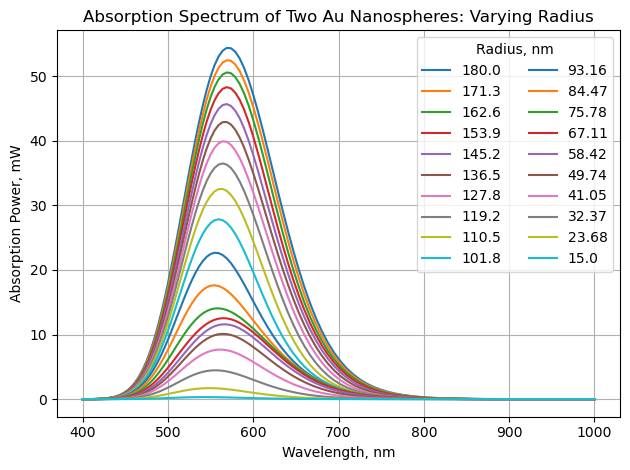

[1.80000000e-01 5.68965517e+02]
[1.71315789e-01 5.68965517e+02]
[1.62631579e-01 5.68965517e+02]
[1.53947368e-01 5.68965517e+02]
[1.45263158e-01 5.68965517e+02]
[1.36578947e-01 5.68965517e+02]
[1.27894737e-01 5.64102564e+02]
[1.19210526e-01 5.64102564e+02]
[1.10526316e-01 5.64102564e+02]
[1.01842105e-01 5.59322034e+02]
[9.31578947e-02 5.54621849e+02]
[8.44736842e-02 5.54621849e+02]
[7.57894737e-02 5.59322034e+02]
[6.71052632e-02 5.64102564e+02]
[5.84210526e-02 5.64102564e+02]
[4.97368421e-02 5.64102564e+02]
[4.10526316e-02 5.59322034e+02]
[3.23684211e-02 5.54621849e+02]
[2.36842105e-02 5.50000000e+02]
[1.50000000e-02 5.40983607e+02]
[1.8e-01 1.0e+03]
[1.71315789e-01 1.00000000e+03]
[1.62631579e-01 1.00000000e+03]
[1.53947368e-01 1.00000000e+03]
[1.45263158e-01 1.00000000e+03]
[1.36578947e-01 1.00000000e+03]
[1.27894737e-01 1.00000000e+03]
[1.19210526e-01 1.00000000e+03]
[1.10526316e-01 1.00000000e+03]
[1.01842105e-01 1.00000000e+03]
[9.31578947e-02 1.00000000e+03]
[8.44736842e-02 1.0000

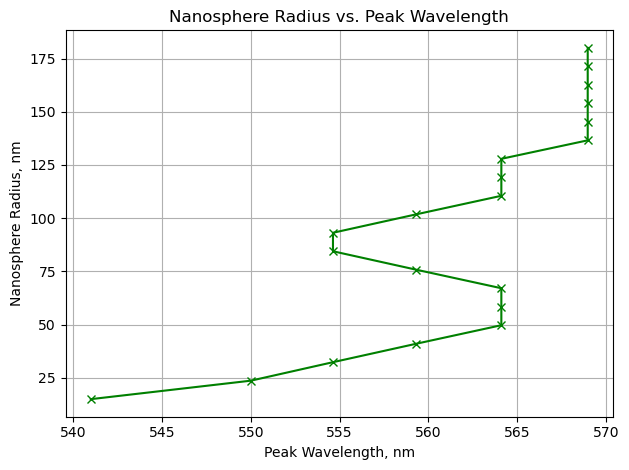

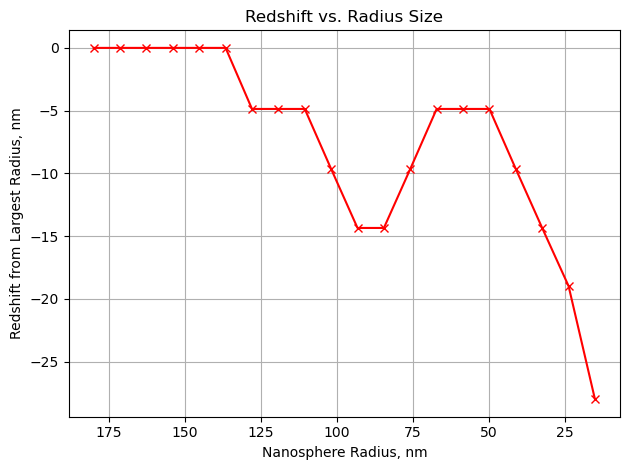

In [4]:
max_wvls_ab = [] #to store the wavelength value where the peak occurs
max_wvls_sc = []
index = 0

scatt_data = np.asarray(scatt_data)
freq_data = np.asarray(freq_data)    #turn both lists into numpy arrays for easy processing.

#for each row, plot the data, find the max wavelength, and use the percentage value for label.
#

for run in scatt_data:
    
    scatt_flux = run
    freqs = freq_data[index]
    radius = radii[index]
    
    plt.plot(1E3/freqs, -1*scatt_flux*1E3, "-", label=f"{str(1E3*round(float(radius),5))[:5]}")
    plt.grid(True, which="both", ls="-")
    plt.xlabel("Wavelength, nm")
    plt.ylabel("Absorption Power, mW")
    #plt.yscale("symlog", linthresh=5E-9) #linear threshold says the region about 0 to scale linearly

    plt.legend(loc="upper right", title = "Radius, nm", ncol=2)
    plt.title("Absorption Spectrum of Two Au Nanospheres: Varying Radius")
    plt.tight_layout()


    #Frequency position of the peak is the index of the max value in scattered flux data, in frequencies.
    # Doing argmin since the scattering peak is the largest negative value.
    
    max_wvl_ab = 1E3/freqs[np.argmin(scatt_flux)]
    
    max_wvl_sc = 1E3/freqs[np.argmax(scatt_flux)]
    
    max_wvls_ab.append([radius, max_wvl_ab])
    max_wvls_sc.append([radius, max_wvl_sc])

    index += 1 #So the percentage value in the percentages array changes for each row.

plt.savefig(fname="Absorption Spectrum of Two Au Nanospheres: Varying Radius",
            dpi=150, 
            bbox_inches="tight")
plt.show()
max_wvls_ab = np.asarray(max_wvls_ab)
max_wvls_sc = np.asarray(max_wvls_sc)

for row in max_wvls_ab:
    print(row)

for row in max_wvls_sc:
    print(row)

#plot curvature vs. peak position

plt.plot(max_wvls_ab[:,1], 1E3*max_wvls_ab[:,0], "gx-", label="Absorption Peaks")
#plt.plot(max_wvls_sc[:,1], 1E3*max_wvls_sc[:,0], "x-",c="orange", label="Scattering Peaks")
plt.grid(True, which="both", ls="-")
plt.xlabel("Peak Wavelength, nm")
plt.ylabel("Nanosphere Radius, nm")
plt.title("Nanosphere Radius vs. Peak Wavelength")
plt.tight_layout()
#plt.legend(loc="upper center")
plt.savefig(fname="Au Nanosphere Radius vs Peak Wavelength",
            dpi=150, 
bbox_inches="tight")
plt.show()

#Plot of redshift vs. AR

redshift_ab = max_wvls_ab[:,1]-max_wvls_ab[0,1] #peak position minus longest cylinder position
redshift_sc = max_wvls_sc[:,1]-max_wvls_sc[0,1]

plt.plot(1E3*radii, redshift_ab, "rx-", label="Absorption Peak")
#plt.plot(1E3*radii, redshift_sc, "bx-", label="Scattering Peak")
plt.gca().invert_xaxis()   #swaps x axis so it plots largest AR to smallest
plt.grid(True, which="both", ls="-")
plt.xlabel("Nanosphere Radius, nm")
plt.ylabel("Redshift from Largest Radius, nm")
plt.title("Redshift vs. Radius Size")
plt.tight_layout()
#plt.legend(loc="upper right")
plt.savefig(fname="2 Redshift vs Radius Size",
            dpi=150, 
            bbox_inches="tight")
plt.show()



In [3]:
# Varying Gap Size

wvl_min = 400E-3
wvl_max = 800E-3

r = 50E-3

freq_data = []  #Going to append all raw sim data arrays, to process and plot after the runs
scatt_data = []


gap_min =2E-3
gap_max =120E-3
gaps = np.linspace(gap_max,gap_min,20)

index = 1

for gap in gaps:
    print(f"##################### Run {index} Starting #######################")
    scatt_flux, freqs = get_spectrum_coupling(r, gap, wvl_min, wvl_max)
    scatt_data.append(scatt_flux)
    freq_data.append(freqs)
    
    index += 1


##################### Run 1 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00178194 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.72 x 0 with resolution 1300
time for set_epsilon = 0.732707 s
-----------
Meep progress: 0.2734615384615385/18.0 = 1.5% done in 4.0s, 259.4s to go
on time step 711 (time=0.273462), 0.00562745 s/step
Meep progress: 0.5511538461538461/18.0 = 3.1% done in 8.0s, 253.3s to go
on time step 1433 (time=0.551154), 0.00554018 s/step
Meep progress: 0.8611538461538462/18.0 = 4.8% done in 12.0s, 238.9s to go
on time step 2239 (time=0.861154), 0.00496635 s/step
Meep progress: 1.1823076923076923/18.0 = 6.6% done in 16.0s, 227.7s to go
on time step 3074 (time=1.18231), 0.00479157 s/step
Meep progress: 1.4673076923076922/18.0 = 8.2% done in 20.0s, 225.5s to go
on time step 3815 (time=1.46731), 0.00540761 s/step
Meep progress: 1.7376923076923076/18.0 = 9.7% done in 24.0s, 224.8s to go
on time step 4518 (tim

run 0 finished at t = 18.0 (46800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000547886 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.72 x 0 with resolution 1300
     sphere, center = (0,0.11,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.11,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 1.16199 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.11576923076923076/108.0 = 0.1% done in 4.0s, 3738.1s to go
on time step 301 (time=0.115769), 0.0133271 s/step
Meep progress: 0.2353846153846154/108.0 = 0.2% done in 8.0s, 3672.1s to go
on time step 612 (time=0.235385), 0.0128887 s/step
Meep progress: 0.35346153846153844/108.0 = 0.3% done in 12.0s, 3663.3s to go
on time step 919 (time=0.353462), 0.0130524 s/step


Meep progress: 107.99346153846153/108.0 = 100.0% done in 3044.1s, 0.2s to go
run 0 finished at t = 108.0 (280800 timesteps)
##################### Run 2 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000800848 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.713846 x 0 with resolution 1300
time for set_epsilon = 0.812843 s
-----------
Meep progress: 0.29730769230769233/18.0 = 1.7% done in 4.0s, 238.4s to go
on time step 773 (time=0.297308), 0.00517866 s/step
Meep progress: 0.6003846153846154/18.0 = 3.3% done in 8.0s, 232.0s to go
on time step 1561 (time=0.600385), 0.00507683 s/step
Meep progress: 0.936923076923077/18.0 = 5.2% done in 12.0s, 218.6s to go
on time step 2437 (time=0.937308), 0.00457082 s/step
Meep progress: 1.278076923076923/18.0 = 7.1% done in 16.0s, 209.4s to go
on time step 3324 (time=1.27846), 0.00451195 s/step
Meep progress: 1.6242307692307691/18.0 = 9.0% done in 20.0s, 201.7s to go
on time step 4224 (t

run 0 finished at t = 18.0 (46800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00087285 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.713846 x 0 with resolution 1300
     sphere, center = (0,0.106895,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.106895,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 1.08375 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.10307692307692308/108.0 = 0.1% done in 4.0s, 4195.2s to go
on time step 268 (time=0.103077), 0.0149549 s/step
Meep progress: 0.22615384615384615/108.0 = 0.2% done in 8.0s, 3817.7s to go
on time step 588 (time=0.226154), 0.0125073 s/step
Meep progress: 0.33653846153846156/108.0 = 0.3% done in 12.0s, 3843.0s to go
on time step 875 (time=0.336538), 0.013

run 0 finished at t = 108.0 (280800 timesteps)
##################### Run 3 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000898123 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.707692 x 0 with resolution 1300
time for set_epsilon = 0.685954 s
-----------
Meep progress: 0.3153846153846154/18.0 = 1.8% done in 4.0s, 224.4s to go
on time step 820 (time=0.315385), 0.0048812 s/step
Meep progress: 0.6242307692307693/18.0 = 3.5% done in 8.0s, 222.8s to go
on time step 1623 (time=0.624231), 0.00498212 s/step
Meep progress: 0.9342307692307692/18.0 = 5.2% done in 12.0s, 219.3s to go
on time step 2429 (time=0.934231), 0.00496736 s/step
Meep progress: 1.2523076923076923/18.0 = 7.0% done in 16.0s, 214.1s to go
on time step 3256 (time=1.25231), 0.00483683 s/step
Meep progress: 1.5761538461538462/18.0 = 8.8% done in 20.0s, 208.5s to go
on time step 4098 (time=1.57615), 0.00475312 s/step
Meep progress: 1.8996153846153847/18.0 = 10.6

run 0 finished at t = 18.0 (46800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000539064 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.707692 x 0 with resolution 1300
     sphere, center = (0,0.103789,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.103789,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.689875 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.1580769230769231/108.0 = 0.1% done in 4.0s, 2734.8s to go
on time step 411 (time=0.158077), 0.0097541 s/step
Meep progress: 0.31846153846153846/108.0 = 0.3% done in 8.0s, 2708.9s to go
on time step 828 (time=0.318462), 0.0095971 s/step
Meep progress: 0.47807692307692307/108.0 = 0.4% done in 12.0s, 2702.7s to go
on time step 1243 (time=0.478077), 0.0

run 0 finished at t = 108.0 (280800 timesteps)
##################### Run 4 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000571012 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.701538 x 0 with resolution 1300
time for set_epsilon = 0.605864 s
-----------
Meep progress: 0.35192307692307695/18.0 = 2.0% done in 4.0s, 200.7s to go
on time step 915 (time=0.351923), 0.00437316 s/step
Meep progress: 0.705/18.0 = 3.9% done in 8.0s, 196.3s to go
on time step 1834 (time=0.705385), 0.00435642 s/step
Meep progress: 1.0603846153846155/18.0 = 5.9% done in 12.0s, 191.8s to go
on time step 2758 (time=1.06077), 0.00433081 s/step
Meep progress: 1.416153846153846/18.0 = 7.9% done in 16.0s, 187.4s to go
on time step 3683 (time=1.41654), 0.00432516 s/step
Meep progress: 1.771153846153846/18.0 = 9.8% done in 20.0s, 183.3s to go
on time step 4606 (time=1.77154), 0.00433465 s/step
Meep progress: 2.126923076923077/18.0 = 11.8% done in 24.0s

run 0 finished at t = 18.0 (46800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000530005 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.701538 x 0 with resolution 1300
     sphere, center = (0,0.100684,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.100684,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.690124 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.16115384615384615/108.0 = 0.1% done in 4.0s, 2678.0s to go
on time step 419 (time=0.161154), 0.00955148 s/step
Meep progress: 0.325/108.0 = 0.3% done in 8.0s, 2652.8s to go
on time step 845 (time=0.325), 0.00940021 s/step
Meep progress: 0.48846153846153845/108.0 = 0.5% done in 12.0s, 2644.0s to go
on time step 1270 (time=0.488462), 0.00942434 s/step

run 0 finished at t = 108.0 (280800 timesteps)
##################### Run 5 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000674009 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.695385 x 0 with resolution 1300
time for set_epsilon = 0.604383 s
-----------
Meep progress: 0.34384615384615386/18.0 = 1.9% done in 4.0s, 205.4s to go
on time step 894 (time=0.343846), 0.00447551 s/step
Meep progress: 0.6842307692307692/18.0 = 3.8% done in 8.0s, 202.5s to go
on time step 1779 (time=0.684231), 0.00452051 s/step
Meep progress: 1.0307692307692307/18.0 = 5.7% done in 12.0s, 197.6s to go
on time step 2680 (time=1.03077), 0.00444217 s/step
Meep progress: 1.3907692307692308/18.0 = 7.7% done in 16.0s, 191.2s to go
on time step 3616 (time=1.39077), 0.00427362 s/step
Meep progress: 1.7465384615384616/18.0 = 9.7% done in 20.0s, 186.2s to go
on time step 4541 (time=1.74654), 0.00432685 s/step
Meep progress: 2.1130769230769233/18.0 = 11.

run 0 finished at t = 18.0 (46800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000462055 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.695385 x 0 with resolution 1300
     sphere, center = (0,0.0975789,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0975789,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.612274 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.16423076923076924/108.0 = 0.2% done in 4.0s, 2630.4s to go
on time step 427 (time=0.164231), 0.00938258 s/step
Meep progress: 0.3230769230769231/108.0 = 0.3% done in 8.0s, 2671.0s to go
on time step 840 (time=0.323077), 0.00970338 s/step
Meep progress: 0.48538461538461536/108.0 = 0.4% done in 12.0s, 2663.3s to go
on time step 1262 (time=0.485385),

run 0 finished at t = 108.0 (280800 timesteps)
##################### Run 6 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000509977 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.689231 x 0 with resolution 1300
time for set_epsilon = 0.589029 s
-----------
Meep progress: 0.3557692307692308/18.0 = 2.0% done in 4.0s, 198.6s to go
on time step 925 (time=0.355769), 0.00432869 s/step
Meep progress: 0.7115384615384616/18.0 = 4.0% done in 8.0s, 194.5s to go
on time step 1850 (time=0.711538), 0.00432484 s/step
Meep progress: 1.0673076923076923/18.0 = 5.9% done in 12.0s, 190.5s to go
on time step 2775 (time=1.06731), 0.00432461 s/step
Meep progress: 1.4234615384615386/18.0 = 7.9% done in 16.0s, 186.4s to go
on time step 3701 (time=1.42346), 0.00432254 s/step
Meep progress: 1.778076923076923/18.0 = 9.9% done in 20.0s, 182.6s to go
on time step 4623 (time=1.77808), 0.0043402 s/step
Meep progress: 2.1334615384615385/18.0 = 11.9% 

run 0 finished at t = 18.0 (46800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000503063 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.689231 x 0 with resolution 1300
     sphere, center = (0,0.0944737,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0944737,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.664317 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.16576923076923078/108.0 = 0.2% done in 4.0s, 2607.7s to go
on time step 431 (time=0.165769), 0.00930115 s/step
Meep progress: 0.3334615384615385/108.0 = 0.3% done in 8.0s, 2586.0s to go
on time step 867 (time=0.333462), 0.00917454 s/step
Meep progress: 0.5007692307692307/108.0 = 0.5% done in 12.0s, 2579.3s to go
on time step 1302 (time=0.500769), 

run 0 finished at t = 108.0 (280800 timesteps)
##################### Run 7 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00051403 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.683077 x 0 with resolution 1300
time for set_epsilon = 0.578917 s
-----------
Meep progress: 0.35384615384615387/18.0 = 2.0% done in 4.0s, 199.5s to go
on time step 920 (time=0.353846), 0.00434913 s/step
Meep progress: 0.7126923076923077/18.0 = 4.0% done in 8.0s, 194.1s to go
on time step 1854 (time=0.713077), 0.00428703 s/step
Meep progress: 1.0746153846153845/18.0 = 6.0% done in 12.0s, 189.1s to go
on time step 2795 (time=1.075), 0.00425243 s/step
Meep progress: 1.4365384615384615/18.0 = 8.0% done in 16.0s, 184.6s to go
on time step 3736 (time=1.43692), 0.004252 s/step
Meep progress: 1.7973076923076923/18.0 = 10.0% done in 20.0s, 180.4s to go
on time step 4674 (time=1.79769), 0.00426779 s/step
Meep progress: 2.1580769230769232/18.0 = 12.0% d

run 0 finished at t = 18.0 (46800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000522137 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.683077 x 0 with resolution 1300
     sphere, center = (0,0.0913684,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0913684,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.658324 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.16653846153846155/108.0 = 0.2% done in 4.0s, 2590.7s to go
on time step 433 (time=0.166538), 0.00924065 s/step
Meep progress: 0.33384615384615385/108.0 = 0.3% done in 8.0s, 2582.1s to go
on time step 868 (time=0.333846), 0.00920676 s/step
Meep progress: 0.5011538461538462/108.0 = 0.5% done in 12.0s, 2575.5s to go
on time step 1304 (time=0.501538),

run 0 finished at t = 108.0 (280800 timesteps)
##################### Run 8 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000514984 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.676154 x 0 with resolution 1300
time for set_epsilon = 0.60134 s
-----------
Meep progress: 0.3596153846153846/18.0 = 2.0% done in 4.0s, 196.4s to go
on time step 935 (time=0.359615), 0.00428228 s/step
Meep progress: 0.7196153846153847/18.0 = 4.0% done in 8.0s, 192.2s to go
on time step 1871 (time=0.719615), 0.00427489 s/step
Meep progress: 1.0826923076923076/18.0 = 6.0% done in 12.0s, 187.6s to go
on time step 2815 (time=1.08269), 0.00423804 s/step
Meep progress: 1.4465384615384616/18.0 = 8.0% done in 16.0s, 183.2s to go
on time step 3761 (time=1.44654), 0.00423146 s/step
Meep progress: 1.8076923076923077/18.0 = 10.0% done in 20.0s, 179.3s to go
on time step 4700 (time=1.80769), 0.00426361 s/step
Meep progress: 2.17/18.0 = 12.1% done in 24.0

run 0 finished at t = 18.0 (46800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00051403 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.676154 x 0 with resolution 1300
     sphere, center = (0,0.0882632,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0882632,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.651838 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.16653846153846155/108.0 = 0.2% done in 4.0s, 2593.8s to go
on time step 433 (time=0.166538), 0.00925184 s/step
Meep progress: 0.3346153846153846/108.0 = 0.3% done in 8.0s, 2576.0s to go
on time step 871 (time=0.335), 0.0091532 s/step
Meep progress: 0.5030769230769231/108.0 = 0.5% done in 12.0s, 2565.8s to go
on time step 1309 (time=0.503462), 0.009

run 0 finished at t = 108.0 (280800 timesteps)
##################### Run 9 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000498056 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.67 x 0 with resolution 1300
time for set_epsilon = 0.567317 s
-----------
Meep progress: 0.3669230769230769/18.0 = 2.0% done in 4.0s, 192.3s to go
on time step 954 (time=0.366923), 0.00419558 s/step
Meep progress: 0.7353846153846154/18.0 = 4.1% done in 8.0s, 188.0s to go
on time step 1912 (time=0.735385), 0.00417864 s/step
Meep progress: 1.103846153846154/18.0 = 6.1% done in 12.0s, 183.8s to go
on time step 2870 (time=1.10385), 0.00417872 s/step
Meep progress: 1.4726923076923077/18.0 = 8.2% done in 16.0s, 179.7s to go
on time step 3830 (time=1.47308), 0.00417079 s/step
Meep progress: 1.841923076923077/18.0 = 10.2% done in 20.0s, 175.6s to go
on time step 4790 (time=1.84231), 0.00416797 s/step
Meep progress: 2.212307692307692/18.0 = 12.3% done

run 0 finished at t = 18.0 (46800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000515938 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.67 x 0 with resolution 1300
     sphere, center = (0,0.0851579,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0851579,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.642614 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.16923076923076924/108.0 = 0.2% done in 4.0s, 2552.3s to go
on time step 440 (time=0.169231), 0.00910382 s/step
Meep progress: 0.3403846153846154/108.0 = 0.3% done in 8.0s, 2533.8s to go
on time step 885 (time=0.340385), 0.00899941 s/step
Meep progress: 0.51/108.0 = 0.5% done in 12.0s, 2532.9s to go
on time step 1326 (time=0.51), 0.00908391 s/step
Meep

run 0 finished at t = 108.0 (280800 timesteps)
##################### Run 10 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000499964 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.663846 x 0 with resolution 1300
time for set_epsilon = 0.565907 s
-----------
Meep progress: 0.3680769230769231/18.0 = 2.0% done in 4.0s, 191.8s to go
on time step 957 (time=0.368077), 0.00418388 s/step
Meep progress: 0.7388461538461538/18.0 = 4.1% done in 8.0s, 187.0s to go
on time step 1922 (time=0.739231), 0.0041484 s/step
Meep progress: 1.0669230769230769/18.0 = 5.9% done in 12.0s, 190.6s to go
on time step 2775 (time=1.06731), 0.00469298 s/step
Meep progress: 1.4346153846153846/18.0 = 8.0% done in 16.0s, 184.8s to go
on time step 3732 (time=1.43538), 0.00418439 s/step
Meep progress: 1.801923076923077/18.0 = 10.0% done in 20.0s, 179.9s to go
on time step 4687 (time=1.80269), 0.00418953 s/step
Meep progress: 2.166153846153846/18.0 = 12.0%

run 0 finished at t = 18.0 (46800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000520945 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.663846 x 0 with resolution 1300
     sphere, center = (0,0.0820526,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0820526,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.635788 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.1696153846153846/108.0 = 0.2% done in 4.0s, 2543.8s to go
on time step 441 (time=0.169615), 0.00907363 s/step
Meep progress: 0.33115384615384613/108.0 = 0.3% done in 8.0s, 2601.6s to go
on time step 862 (time=0.331538), 0.00952891 s/step
Meep progress: 0.4807692307692308/108.0 = 0.4% done in 12.0s, 2685.0s to go
on time step 1251 (time=0.481154), 

run 0 finished at t = 108.0 (280800 timesteps)
##################### Run 11 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000492096 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.657692 x 0 with resolution 1300
time for set_epsilon = 0.567375 s
-----------
Meep progress: 0.3688461538461538/18.0 = 2.0% done in 4.0s, 191.4s to go
on time step 959 (time=0.368846), 0.00417441 s/step
Meep progress: 0.7392307692307692/18.0 = 4.1% done in 8.0s, 187.0s to go
on time step 1922 (time=0.739231), 0.00415708 s/step
Meep progress: 1.1026923076923076/18.0 = 6.1% done in 12.0s, 184.0s to go
on time step 2867 (time=1.10269), 0.00423501 s/step
Meep progress: 1.468076923076923/18.0 = 8.2% done in 16.0s, 180.3s to go
on time step 3817 (time=1.46808), 0.00421297 s/step
Meep progress: 1.8384615384615384/18.0 = 10.2% done in 20.0s, 175.9s to go
on time step 4781 (time=1.83885), 0.00415348 s/step
Meep progress: 2.208846153846154/18.0 = 12.3

run 0 finished at t = 18.0 (46800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000518799 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.657692 x 0 with resolution 1300
     sphere, center = (0,0.0789474,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0789474,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.644746 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.16884615384615384/108.0 = 0.2% done in 4.0s, 2556.9s to go
on time step 439 (time=0.168846), 0.0091202 s/step
Meep progress: 0.3373076923076923/108.0 = 0.3% done in 8.0s, 2556.6s to go
on time step 877 (time=0.337308), 0.00914551 s/step
Meep progress: 0.5084615384615384/108.0 = 0.5% done in 12.0s, 2539.7s to go
on time step 1322 (time=0.508462), 0

run 0 finished at t = 108.0 (280800 timesteps)
##################### Run 12 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000695229 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.651538 x 0 with resolution 1300
time for set_epsilon = 0.563574 s
-----------
Meep progress: 0.37153846153846154/18.0 = 2.1% done in 4.0s, 189.9s to go
on time step 966 (time=0.371538), 0.00414243 s/step
Meep progress: 0.7434615384615385/18.0 = 4.1% done in 8.0s, 185.7s to go
on time step 1934 (time=0.743846), 0.00413557 s/step
Meep progress: 1.116923076923077/18.0 = 6.2% done in 12.0s, 181.5s to go
on time step 2905 (time=1.11731), 0.00412227 s/step
Meep progress: 1.4907692307692308/18.0 = 8.3% done in 16.0s, 177.3s to go
on time step 3877 (time=1.49115), 0.00411694 s/step
Meep progress: 1.8642307692307691/18.0 = 10.4% done in 20.0s, 173.2s to go
on time step 4848 (time=1.86462), 0.0041208 s/step
Meep progress: 2.227692307692308/18.0 = 12.4

run 0 finished at t = 18.0 (46800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000495911 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.651538 x 0 with resolution 1300
     sphere, center = (0,0.0758421,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0758421,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.632706 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.1723076923076923/108.0 = 0.2% done in 4.0s, 2503.7s to go
on time step 448 (time=0.172308), 0.00893074 s/step
Meep progress: 0.34692307692307695/108.0 = 0.3% done in 8.0s, 2482.9s to go
on time step 903 (time=0.347308), 0.00881112 s/step
Meep progress: 0.5211538461538462/108.0 = 0.5% done in 12.0s, 2476.0s to go
on time step 1356 (time=0.521538), 

run 0 finished at t = 108.0 (280800 timesteps)
##################### Run 13 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000751019 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.645385 x 0 with resolution 1300
time for set_epsilon = 0.565429 s
-----------
Meep progress: 0.37461538461538463/18.0 = 2.1% done in 4.0s, 188.3s to go
on time step 974 (time=0.374615), 0.00410825 s/step
Meep progress: 0.7526923076923077/18.0 = 4.2% done in 8.0s, 183.4s to go
on time step 1957 (time=0.752692), 0.00407117 s/step
Meep progress: 1.1242307692307691/18.0 = 6.2% done in 12.0s, 180.2s to go
on time step 2923 (time=1.12423), 0.00414148 s/step
Meep progress: 1.501153846153846/18.0 = 8.3% done in 16.0s, 176.0s to go
on time step 3903 (time=1.50115), 0.00408493 s/step
Meep progress: 1.8784615384615384/18.0 = 10.4% done in 20.0s, 171.7s to go
on time step 4884 (time=1.87846), 0.00407749 s/step
Meep progress: 2.256923076923077/18.0 = 12.

run 0 finished at t = 18.0 (46800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000494003 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.645385 x 0 with resolution 1300
     sphere, center = (0,0.0727368,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0727368,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.627289 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.17346153846153847/108.0 = 0.2% done in 4.0s, 2487.3s to go
on time step 451 (time=0.173462), 0.00887259 s/step
Meep progress: 0.34884615384615386/108.0 = 0.3% done in 8.0s, 2469.5s to go
on time step 907 (time=0.348846), 0.00877263 s/step
Meep progress: 0.5242307692307693/108.0 = 0.5% done in 12.0s, 2460.9s to go
on time step 1363 (time=0.524231),

run 0 finished at t = 108.0 (280800 timesteps)
##################### Run 14 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000535965 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.639231 x 0 with resolution 1300
time for set_epsilon = 0.551936 s
-----------
Meep progress: 0.3719230769230769/18.0 = 2.1% done in 4.0s, 189.7s to go
on time step 967 (time=0.371923), 0.00414008 s/step
Meep progress: 0.7457692307692307/18.0 = 4.1% done in 8.0s, 185.2s to go
on time step 1939 (time=0.745769), 0.00411623 s/step
Meep progress: 1.121923076923077/18.0 = 6.2% done in 12.0s, 180.6s to go
on time step 2917 (time=1.12192), 0.00409277 s/step
Meep progress: 1.49/18.0 = 8.3% done in 16.0s, 177.4s to go
on time step 3874 (time=1.49), 0.00418068 s/step
Meep progress: 1.8626923076923076/18.0 = 10.3% done in 20.0s, 173.4s to go
on time step 4843 (time=1.86269), 0.00412996 s/step
Meep progress: 2.2388461538461537/18.0 = 12.4% done in 24.0s,

run 0 finished at t = 18.0 (46800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000510931 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.639231 x 0 with resolution 1300
     sphere, center = (0,0.0696316,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0696316,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.625273 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.17692307692307693/108.0 = 0.2% done in 4.0s, 2440.8s to go
on time step 460 (time=0.176923), 0.00870693 s/step
Meep progress: 0.355/108.0 = 0.3% done in 8.0s, 2427.6s to go
on time step 923 (time=0.355), 0.00864008 s/step
Meep progress: 0.5326923076923077/108.0 = 0.5% done in 12.0s, 2422.5s to go
on time step 1385 (time=0.532692), 0.00866003 s/ste

run 0 finished at t = 108.0 (280800 timesteps)
##################### Run 15 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000504017 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.633077 x 0 with resolution 1300
time for set_epsilon = 0.543499 s
-----------
Meep progress: 0.37653846153846154/18.0 = 2.1% done in 4.0s, 187.3s to go
on time step 979 (time=0.376538), 0.00408694 s/step
Meep progress: 0.7553846153846154/18.0 = 4.2% done in 8.0s, 182.7s to go
on time step 1964 (time=0.755385), 0.00406106 s/step
Meep progress: 1.1346153846153846/18.0 = 6.3% done in 12.0s, 178.5s to go
on time step 2950 (time=1.13462), 0.00406024 s/step
Meep progress: 1.511923076923077/18.0 = 8.4% done in 16.0s, 174.6s to go
on time step 3931 (time=1.51192), 0.00407897 s/step
Meep progress: 1.8907692307692308/18.0 = 10.5% done in 20.0s, 170.5s to go
on time step 4916 (time=1.89077), 0.00406256 s/step
Meep progress: 2.267692307692308/18.0 = 12.

run 0 finished at t = 18.0 (46800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000513077 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.633077 x 0 with resolution 1300
     sphere, center = (0,0.0665263,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0665263,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.619062 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.17807692307692308/108.0 = 0.2% done in 4.0s, 2422.9s to go
on time step 463 (time=0.178077), 0.00864328 s/step
Meep progress: 0.35923076923076924/108.0 = 0.3% done in 8.0s, 2400.1s to go
on time step 934 (time=0.359231), 0.00850854 s/step
Meep progress: 0.54/108.0 = 0.5% done in 12.0s, 2391.4s to go
on time step 1404 (time=0.54), 0.00852472 s/step

run 0 finished at t = 108.0 (280800 timesteps)
##################### Run 16 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000545025 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.626923 x 0 with resolution 1300
time for set_epsilon = 0.536265 s
-----------
Meep progress: 0.3892307692307692/18.0 = 2.2% done in 4.0s, 181.1s to go
on time step 1012 (time=0.389231), 0.00395569 s/step
Meep progress: 0.7811538461538462/18.0 = 4.3% done in 8.0s, 176.5s to go
on time step 2031 (time=0.781154), 0.00392827 s/step
Meep progress: 1.1723076923076923/18.0 = 6.5% done in 12.0s, 172.4s to go
on time step 3048 (time=1.17231), 0.00393588 s/step
Meep progress: 1.563076923076923/18.0 = 8.7% done in 16.0s, 168.4s to go
on time step 4065 (time=1.56346), 0.00393696 s/step
Meep progress: 1.9526923076923077/18.0 = 10.8% done in 20.0s, 164.5s to go
on time step 5078 (time=1.95308), 0.00394955 s/step
Meep progress: 2.337307692307692/18.0 = 13.

run 0 finished at t = 18.0 (46800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000504971 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.626923 x 0 with resolution 1300
     sphere, center = (0,0.0634211,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0634211,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.615407 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.18115384615384617/108.0 = 0.2% done in 4.0s, 2381.3s to go
on time step 471 (time=0.181154), 0.00849507 s/step
Meep progress: 0.365/108.0 = 0.3% done in 8.0s, 2359.7s to go
on time step 949 (time=0.365), 0.00836899 s/step
Meep progress: 0.5488461538461539/108.0 = 0.5% done in 12.0s, 2350.8s to go
on time step 1427 (time=0.548846), 0.00837849 s/ste

run 0 finished at t = 108.0 (280800 timesteps)
##################### Run 17 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000499964 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.620769 x 0 with resolution 1300
time for set_epsilon = 0.531711 s
-----------
Meep progress: 0.39/18.0 = 2.2% done in 4.0s, 180.8s to go
on time step 1014 (time=0.39), 0.00394822 s/step
Meep progress: 0.7815384615384615/18.0 = 4.3% done in 8.0s, 176.4s to go
on time step 2032 (time=0.781538), 0.00392989 s/step
Meep progress: 1.1726923076923077/18.0 = 6.5% done in 12.0s, 172.3s to go
on time step 3049 (time=1.17269), 0.00393594 s/step
Meep progress: 1.5661538461538462/18.0 = 8.7% done in 16.0s, 168.0s to go
on time step 4072 (time=1.56615), 0.00391254 s/step
Meep progress: 1.9584615384615385/18.0 = 10.9% done in 20.0s, 163.9s to go
on time step 5092 (time=1.95846), 0.0039241 s/step
Meep progress: 2.351153846153846/18.0 = 13.1% done in 24.0s, 

run 0 finished at t = 18.0 (46800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000500917 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.620769 x 0 with resolution 1300
     sphere, center = (0,0.0603158,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0603158,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.618757 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.18307692307692308/108.0 = 0.2% done in 4.0s, 2356.0s to go
on time step 476 (time=0.183077), 0.00840474 s/step
Meep progress: 0.3676923076923077/108.0 = 0.3% done in 8.0s, 2342.2s to go
on time step 956 (time=0.367692), 0.00833436 s/step
Meep progress: 0.553076923076923/108.0 = 0.5% done in 12.0s, 2332.1s to go
on time step 1438 (time=0.553077), 0

run 0 finished at t = 108.0 (280800 timesteps)
##################### Run 18 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000499964 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.614615 x 0 with resolution 1300
time for set_epsilon = 0.526443 s
-----------
Meep progress: 0.3996153846153846/18.0 = 2.2% done in 4.0s, 176.3s to go
on time step 1039 (time=0.399615), 0.00385312 s/step
Meep progress: 0.8/18.0 = 4.4% done in 8.0s, 172.1s to go
on time step 2080 (time=0.8), 0.00384426 s/step
Meep progress: 1.2003846153846154/18.0 = 6.7% done in 12.0s, 168.0s to go
on time step 3122 (time=1.20077), 0.00384224 s/step
Meep progress: 1.5961538461538463/18.0 = 8.9% done in 16.0s, 164.5s to go
on time step 4151 (time=1.59654), 0.0038874 s/step
Meep progress: 1.9965384615384616/18.0 = 11.1% done in 20.0s, 160.4s to go
on time step 5192 (time=1.99692), 0.00384303 s/step
Meep progress: 2.396923076923077/18.0 = 13.3% done in 24.0s, 15

run 0 finished at t = 18.0 (46800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000499964 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.614615 x 0 with resolution 1300
     sphere, center = (0,0.0572105,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0572105,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.604111 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.185/108.0 = 0.2% done in 4.0s, 2334.8s to go
on time step 481 (time=0.185), 0.00832922 s/step
Meep progress: 0.3723076923076923/108.0 = 0.3% done in 8.0s, 2315.8s to go
on time step 968 (time=0.372308), 0.00822187 s/step
Meep progress: 0.5588461538461539/108.0 = 0.5% done in 12.0s, 2309.7s to go
on time step 1453 (time=0.558846), 0.00825129 s/step

run 0 finished at t = 108.0 (280800 timesteps)
##################### Run 19 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000506163 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.608462 x 0 with resolution 1300
time for set_epsilon = 0.519171 s
-----------
Meep progress: 0.4003846153846154/18.0 = 2.2% done in 4.0s, 175.9s to go
on time step 1041 (time=0.400385), 0.00384326 s/step
Meep progress: 0.8042307692307692/18.0 = 4.5% done in 8.0s, 171.1s to go
on time step 2091 (time=0.804231), 0.00381181 s/step
Meep progress: 1.2073076923076924/18.0 = 6.7% done in 12.0s, 167.0s to go
on time step 3139 (time=1.20731), 0.00381743 s/step
Meep progress: 1.6107692307692307/18.0 = 8.9% done in 16.0s, 162.9s to go
on time step 4188 (time=1.61077), 0.0038149 s/step
Meep progress: 2.0096153846153846/18.0 = 11.2% done in 20.0s, 159.2s to go
on time step 5225 (time=2.00962), 0.00385896 s/step
Meep progress: 2.4107692307692306/18.0 = 13

run 0 finished at t = 18.0 (46800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000512123 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.608462 x 0 with resolution 1300
     sphere, center = (0,0.0541053,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0541053,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.610229 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.18730769230769231/108.0 = 0.2% done in 4.0s, 2303.2s to go
on time step 487 (time=0.187308), 0.00821683 s/step
Meep progress: 0.3769230769230769/108.0 = 0.3% done in 8.0s, 2285.0s to go
on time step 980 (time=0.376923), 0.00811507 s/step
Meep progress: 0.5665384615384615/108.0 = 0.5% done in 12.0s, 2276.9s to go
on time step 1473 (time=0.566538), 

run 0 finished at t = 108.0 (280800 timesteps)
##################### Run 20 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000683069 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.602308 x 0 with resolution 1300
time for set_epsilon = 0.510069 s
-----------
Meep progress: 0.3823076923076923/18.0 = 2.1% done in 4.0s, 184.5s to go
on time step 994 (time=0.382308), 0.00402801 s/step
Meep progress: 0.77/18.0 = 4.3% done in 8.0s, 179.1s to go
on time step 2002 (time=0.77), 0.00396931 s/step
Meep progress: 1.1753846153846155/18.0 = 6.5% done in 12.0s, 171.9s to go
on time step 3056 (time=1.17538), 0.00379787 s/step
Meep progress: 1.571923076923077/18.0 = 8.7% done in 16.0s, 167.3s to go
on time step 4087 (time=1.57192), 0.00388043 s/step
Meep progress: 1.9896153846153846/18.0 = 11.1% done in 20.0s, 161.0s to go
on time step 5173 (time=1.98962), 0.00368593 s/step
Meep progress: 2.414230769230769/18.0 = 13.4% done in 24.0s, 1

run 0 finished at t = 18.0 (46800 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000679016 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.602308 x 0 with resolution 1300
     sphere, center = (0,0.051,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.051,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.636501 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.18/108.0 = 0.2% done in 4.0s, 2400.5s to go
on time step 468 (time=0.18), 0.00856337 s/step
Meep progress: 0.365/108.0 = 0.3% done in 8.0s, 2363.5s to go
on time step 949 (time=0.365), 0.00832863 s/step
Meep progress: 0.553076923076923/108.0 = 0.5% done in 12.0s, 2335.6s to go
on time step 1438 (time=0.553077), 0.00819463 s/step
Meep progress: 0.744615384

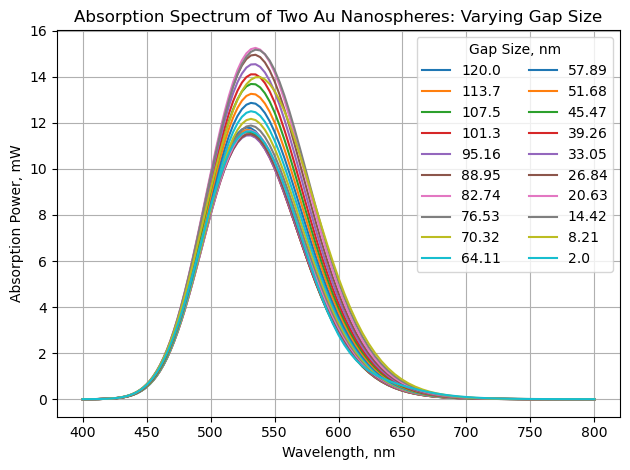

[1.20e-01 5.28e+02]
[1.13789474e-01 5.28000000e+02]
[1.07578947e-01 5.28000000e+02]
[1.01368421e-01 5.28000000e+02]
[9.51578947e-02 5.31543624e+02]
[8.89473684e-02 5.31543624e+02]
[8.27368421e-02 5.31543624e+02]
[7.65263158e-02 5.31543624e+02]
[7.03157895e-02 5.31543624e+02]
[6.41052632e-02 5.31543624e+02]
[5.78947368e-02 5.31543624e+02]
[5.16842105e-02 5.31543624e+02]
[4.54736842e-02 5.31543624e+02]
[3.92631579e-02 5.31543624e+02]
[3.30526316e-02 5.35135135e+02]
[2.68421053e-02 5.35135135e+02]
[2.06315789e-02 5.35135135e+02]
[1.44210526e-02 5.35135135e+02]
[8.21052632e-03 5.38775510e+02]
[2.00000000e-03 5.31543624e+02]
[1.2e-01 8.0e+02]
[1.13789474e-01 8.00000000e+02]
[1.07578947e-01 8.00000000e+02]
[1.01368421e-01 8.00000000e+02]
[9.51578947e-02 8.00000000e+02]
[8.89473684e-02 8.00000000e+02]
[8.27368421e-02 8.00000000e+02]
[7.65263158e-02 8.00000000e+02]
[7.03157895e-02 8.00000000e+02]
[6.41052632e-02 8.00000000e+02]
[5.78947368e-02 8.00000000e+02]
[5.16842105e-02 8.00000000e+02]
[4

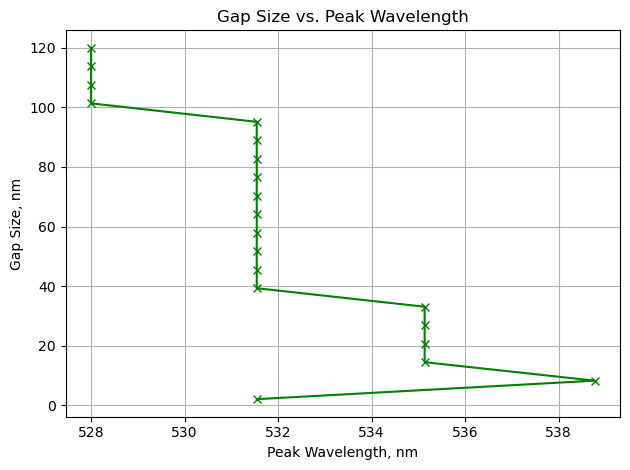

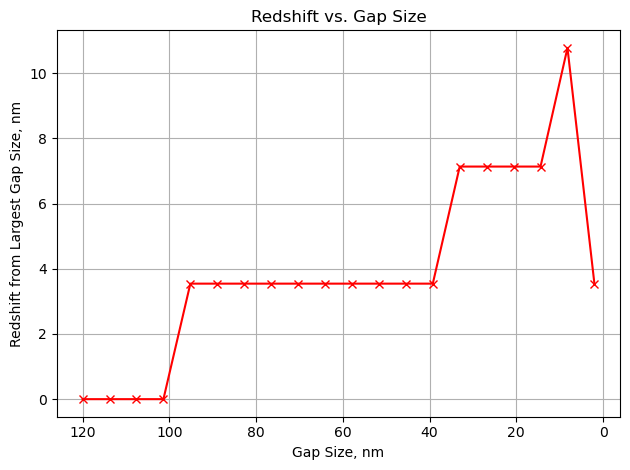

In [4]:
max_wvls_ab = [] #to store the wavelength value where the peak occurs
max_wvls_sc = []
index = 0

scatt_data = np.asarray(scatt_data)
freq_data = np.asarray(freq_data)    #turn both lists into numpy arrays for easy processing.

#for each row, plot the data, find the max wavelength, and use the percentage value for label.
#

for run in scatt_data:
    
    scatt_flux = run
    freqs = freq_data[index]
    gap = gaps[index]
    
    plt.plot(1E3/freqs, -1*scatt_flux*1E3, "-", label=f"{str(1E3*round(float(gap),5))[:5]}")
    plt.grid(True, which="both", ls="-")
    plt.xlabel("Wavelength, nm")
    plt.ylabel("Absorption Power, mW")
    #plt.yscale("symlog", linthresh=5E-9) #linear threshold says the region about 0 to scale linearly

    plt.legend(loc="upper right", title = "Gap Size, nm", ncol=2)
    plt.title("Absorption Spectrum of Two Au Nanospheres: Varying Gap Size")
    plt.tight_layout()


    #Frequency position of the peak is the index of the max value in scattered flux data, in frequencies.
    # Doing argmin since the scattering peak is the largest negative value.
    
    max_wvl_ab = 1E3/freqs[np.argmin(scatt_flux)]
    
    max_wvl_sc = 1E3/freqs[np.argmax(scatt_flux)]
    
    max_wvls_ab.append([gap, max_wvl_ab])
    max_wvls_sc.append([gap, max_wvl_sc])

    index += 1 #So the percentage value in the percentages array changes for each row.

plt.savefig(fname="Absorption Spectrum of Two Au Nanospheres: Varying Gap",
            dpi=150, 
            bbox_inches="tight")
plt.show()
max_wvls_ab = np.asarray(max_wvls_ab)
max_wvls_sc = np.asarray(max_wvls_sc)

for row in max_wvls_ab:
    print(row)

for row in max_wvls_sc:
    print(row)

#plot curvature vs. peak position

plt.plot(max_wvls_ab[:,1], 1E3*max_wvls_ab[:,0], "gx-", label="Absorption Peaks")
#plt.plot(max_wvls_sc[:,1], 1E3*max_wvls_sc[:,0], "x-",c="orange", label="Scattering Peaks")
plt.grid(True, which="both", ls="-")
plt.xlabel("Peak Wavelength, nm")
plt.ylabel("Gap Size, nm")
plt.title("Gap Size vs. Peak Wavelength")
plt.tight_layout()
#plt.legend(loc="upper center")
plt.savefig(fname="Gap vs Peak Wavelength",
            dpi=150, 
            bbox_inches="tight")
plt.show()

#Plot of redshift vs. AR

redshift_ab = max_wvls_ab[:,1]-max_wvls_ab[0,1] #peak position minus longest cylinder position
redshift_sc = max_wvls_sc[:,1]-max_wvls_sc[0,1]

plt.plot(1E3*gaps, redshift_ab, "rx-", label="Absorption Peak")
#plt.plot(1E3*gaps, redshift_sc, "bx-", label="Scattering Peak")
plt.gca().invert_xaxis()   #swaps x axis so it plots largest AR to smallest
plt.grid(True, which="both", ls="-")
plt.xlabel("Gap Size, nm")
plt.ylabel("Redshift from Largest Gap Size, nm")
plt.title("Redshift vs. Gap Size")
plt.tight_layout()
#plt.legend(loc="upper right")
plt.savefig(fname="Redshift vs Gap Size",
            dpi=150, 
            bbox_inches="tight")
plt.show()

